In [97]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [98]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms as T
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [99]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [100]:
DATA_PATH = Path('/content/drive/MyDrive/archive (4)/data')
DATA_PATH

PosixPath('/content/drive/MyDrive/archive (4)/data')

In [101]:
image_list = list(DATA_PATH.glob('*/*.jpg'))
len(image_list)

878

Text(0.5, 1.0, 'Tauros')

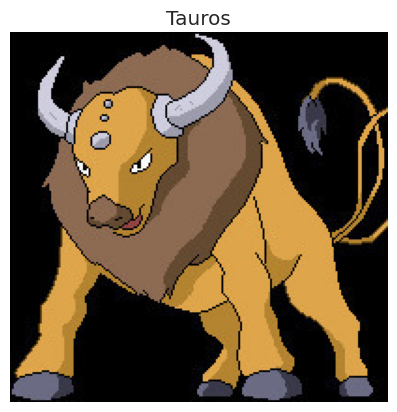

In [102]:
img = random.choice(image_list)
plt.imshow(np.array(Image.open(img)))
plt.axis(False)
plt.title(img.parent.stem)

In [119]:
train_transforms = T.Compose([
    T.RandomHorizontalFlip(0.2),
    T.RandomVerticalFlip(0.2),
    T.Resize(size=(128,128)),
    T.RandomRotation(degrees=30),
    T.RandomResizedCrop(size=(128,128), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    T.ToTensor()
])

test_transforms = T.Compose([
    T.Resize(size=(128,128)),
    T.ToTensor()
])

Text(0.5, 1.0, 'Charizard')

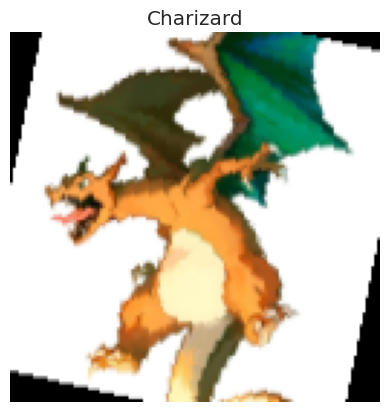

In [120]:
img = random.choice(image_list)
transformed = train_transforms(Image.open(img))
plt.imshow(transformed.permute(1,2,0))
plt.axis('off')
plt.title(img.parent.stem)

In [121]:
len(image_list)

878

In [122]:
labels = list(set(list(img.parent.stem for img in image_list)))
label_encoder = {v:k for k,v in enumerate(labels)}
label_encoder

{'Voltorb': 0,
 'Psyduck': 1,
 'Blastoise': 2,
 'Charizard': 3,
 'Pikachu': 4,
 'Wartortle': 5,
 'Nidoking': 6,
 'Pidgeot': 7,
 'Gengar': 8,
 'Kingler': 9,
 'Diglett': 10,
 'Electrode': 11,
 'Poliwag': 12,
 'Dragonite': 13,
 'Tauros': 14,
 'Magnemite': 15,
 'Bulbasaur': 16,
 'Golem': 17,
 'Jigglypuff': 18,
 'Abra': 19}

In [123]:
random.shuffle(image_list)
train = image_list[:700]
test = image_list[700:]

In [124]:
class ImageDataset(Dataset):
    def __init__(self,image_list,transform,label=label_encoder):
        super().__init__()
        self.image_list = image_list
        self.transform = transform
        self.label=label
    def __len__(self):
        return len(self.image_list)
    def __getitem__(self, idx):
        img_path = self.image_list[idx]
        img = Image.open(img_path)
        transformed_img = self.transform(img)
        label = self.label[os.path.basename(os.path.dirname(img_path))]  # Adjust this line based on your label extraction logic

        return transformed_img, label


In [125]:
train_data = ImageDataset(train,train_transforms)
test_data = ImageDataset(test,test_transforms)
train_data[0]

(tensor([[[0.0000, 0.0000, 0.6078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.6078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.7216, 0.9765,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.6078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.6078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.7216, 0.9765,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.6078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.6078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.7216, 0.9765,  ...,

In [126]:
bs = 1
train_loader = DataLoader(train_data,batch_size=bs,shuffle=True)
test_loader = DataLoader(test_data,batch_size=1,shuffle=False)

In [177]:
class PokemonModel(nn.Module):
    def __init__(self,input_size=3,output_size=len(labels)):
        super().__init__()
        self.conv_blk1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size,out_channels=32,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=238144,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16,out_features=output_size)
        )

    def forward(self,x):
        x = self.conv_blk1(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

In [178]:
model = PokemonModel().to(device)

In [179]:
!pip install torchinfo

In [180]:
from torchinfo import summary

summary(model,input_size=[1,3,128,128])

Layer (type:depth-idx)                   Output Shape              Param #
PokemonModel                             [1, 20]                   --
├─Sequential: 1-1                        [1, 16, 122, 122]         --
│    └─Conv2d: 2-1                       [1, 32, 126, 126]         896
│    └─ReLU: 2-2                         [1, 32, 126, 126]         --
│    └─Conv2d: 2-3                       [1, 16, 124, 124]         4,624
│    └─ReLU: 2-4                         [1, 16, 124, 124]         --
│    └─MaxPool2d: 2-5                    [1, 16, 122, 122]         --
├─Sequential: 1-2                        [1, 20]                   --
│    └─Linear: 2-6                       [1, 32]                   7,620,640
│    └─ReLU: 2-7                         [1, 32]                   --
│    └─Linear: 2-8                       [1, 16]                   528
│    └─ReLU: 2-9                         [1, 16]                   --
│    └─Linear: 2-10                      [1, 20]                   340
To

In [181]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0.0001)

In [182]:
train_loss_list,test_loss_list = [],[]
epochs = 100

In [183]:
for epoch in range(epochs):
    total_train_loss,total_test_loss = 0,0

    for (X,y) in train_loader:
        model.train()
        optimizer.zero_grad()
        X,y = X.to(device),y.to(device)
        output = model(X)
        train_loss = loss_fn(output,y)
        train_loss.backward()
        optimizer.step()
        total_train_loss += train_loss.item()
        train_loss_list.append(train_loss.item())

    total_train_loss /= len(train_loader)

    for test_batch in test_loader:
        model.eval()
        input,target = test_batch
        input,target = input.to(device),target.to(device)
        output = model(input)
        test_loss = loss_fn(output,target)
        total_test_loss += test_loss.item()
        test_loss_list.append(test_loss.item())
    total_test_loss /= len(test_loader)
    print(f'epoch: {epoch} || test_loss: {total_test_loss} || train_loss: {total_train_loss}')
    if total_test_loss < 1.04:
        break


epoch: 0 || test_loss: 2.861561649970794 || train_loss: 2.892323028870991
epoch: 1 || test_loss: 2.6483241453599393 || train_loss: 2.6430914374334473
epoch: 2 || test_loss: 2.4512735292148053 || train_loss: 2.406323946895344
epoch: 3 || test_loss: 2.4309758389515155 || train_loss: 2.1865845534637836
epoch: 4 || test_loss: 2.011641357721907 || train_loss: 1.9617310063216635
epoch: 5 || test_loss: 1.8562164793021223 || train_loss: 1.798042876191487
epoch: 6 || test_loss: 1.6300358568119366 || train_loss: 1.5908833948201
epoch: 7 || test_loss: 1.6413235877525438 || train_loss: 1.4483332809931433
epoch: 8 || test_loss: 1.5893094427883625 || train_loss: 1.375369707055922
epoch: 9 || test_loss: 1.4061513651617583 || train_loss: 1.2671837986348795
epoch: 10 || test_loss: 1.4809155409653367 || train_loss: 1.2109943922150082
epoch: 11 || test_loss: 1.3936105766961497 || train_loss: 1.12662823591531
epoch: 12 || test_loss: 1.2475825328304004 || train_loss: 1.0629517305647356
epoch: 13 || test_lo

In [184]:
img,label = next(iter(test_loader))
ypred = model(img.to(device))
ypred = torch.argmax(ypred,dim=1)
ypred,label

(tensor([13], device='cuda:0'), tensor([19]))

In [185]:
y_preds =  []
actual = []

model.eval()
with torch.no_grad():
  for X,y in test_loader:
    X,y = X.to(device),y.to(device)
    y_logit = model(X)
    y_pred = torch.argmax(y_logit,dim=1)
    y_preds.append(y_pred)
    actual.append(y)


y_pred_tensor = torch.cat(y_preds)
actual = torch.cat(actual)
y_pred_tensor

tensor([13, 17,  5, 15, 14, 12,  0,  8,  8,  7,  3,  9, 10,  9,  1, 11, 12,  7,
        14,  1, 13, 13,  0,  3,  2, 11,  6,  6,  9,  4,  8, 11, 15,  0, 12,  9,
         5,  1,  4,  9, 11,  5, 12, 17,  7,  6, 13,  8,  2,  2,  4, 11, 13,  7,
        17,  2, 11, 10, 14,  4, 14,  1,  9,  9,  7, 11, 17,  0, 15,  7,  5,  2,
        11,  2, 19, 12, 18, 17,  9, 15,  5,  9, 14, 12, 18,  9,  9, 15, 15,  6,
        17, 18,  9, 12,  5,  4,  9,  9,  8,  9,  0,  4,  6, 13,  7, 19,  8, 16,
         0, 17,  0,  2,  7, 17,  7, 16,  0, 14, 18, 11,  5, 15, 14,  0, 12, 11,
         6, 17,  3, 16,  5,  4,  9,  9, 16, 18,  8, 17,  0, 13, 11, 15,  9, 11,
         9, 14, 11,  1,  8,  8,  9,  8,  1, 14, 14, 13,  3,  4, 13, 15, 19, 12,
        13,  7,  7, 17, 14,  8, 16, 19, 14, 18, 18, 14, 15, 14,  5, 11],
       device='cuda:0')

In [186]:
count = 0
for i in range(len(actual)):
  if actual[i] == y_pred_tensor[i]:
    count += 1

print(count)
print(len(actual))
print(f'Accuracy: {(count / len(actual)) * 100}%')

135
178
Accuracy: 75.84269662921348%


In [187]:
cm = confusion_matrix(actual.cpu(),y_pred_tensor.cpu())

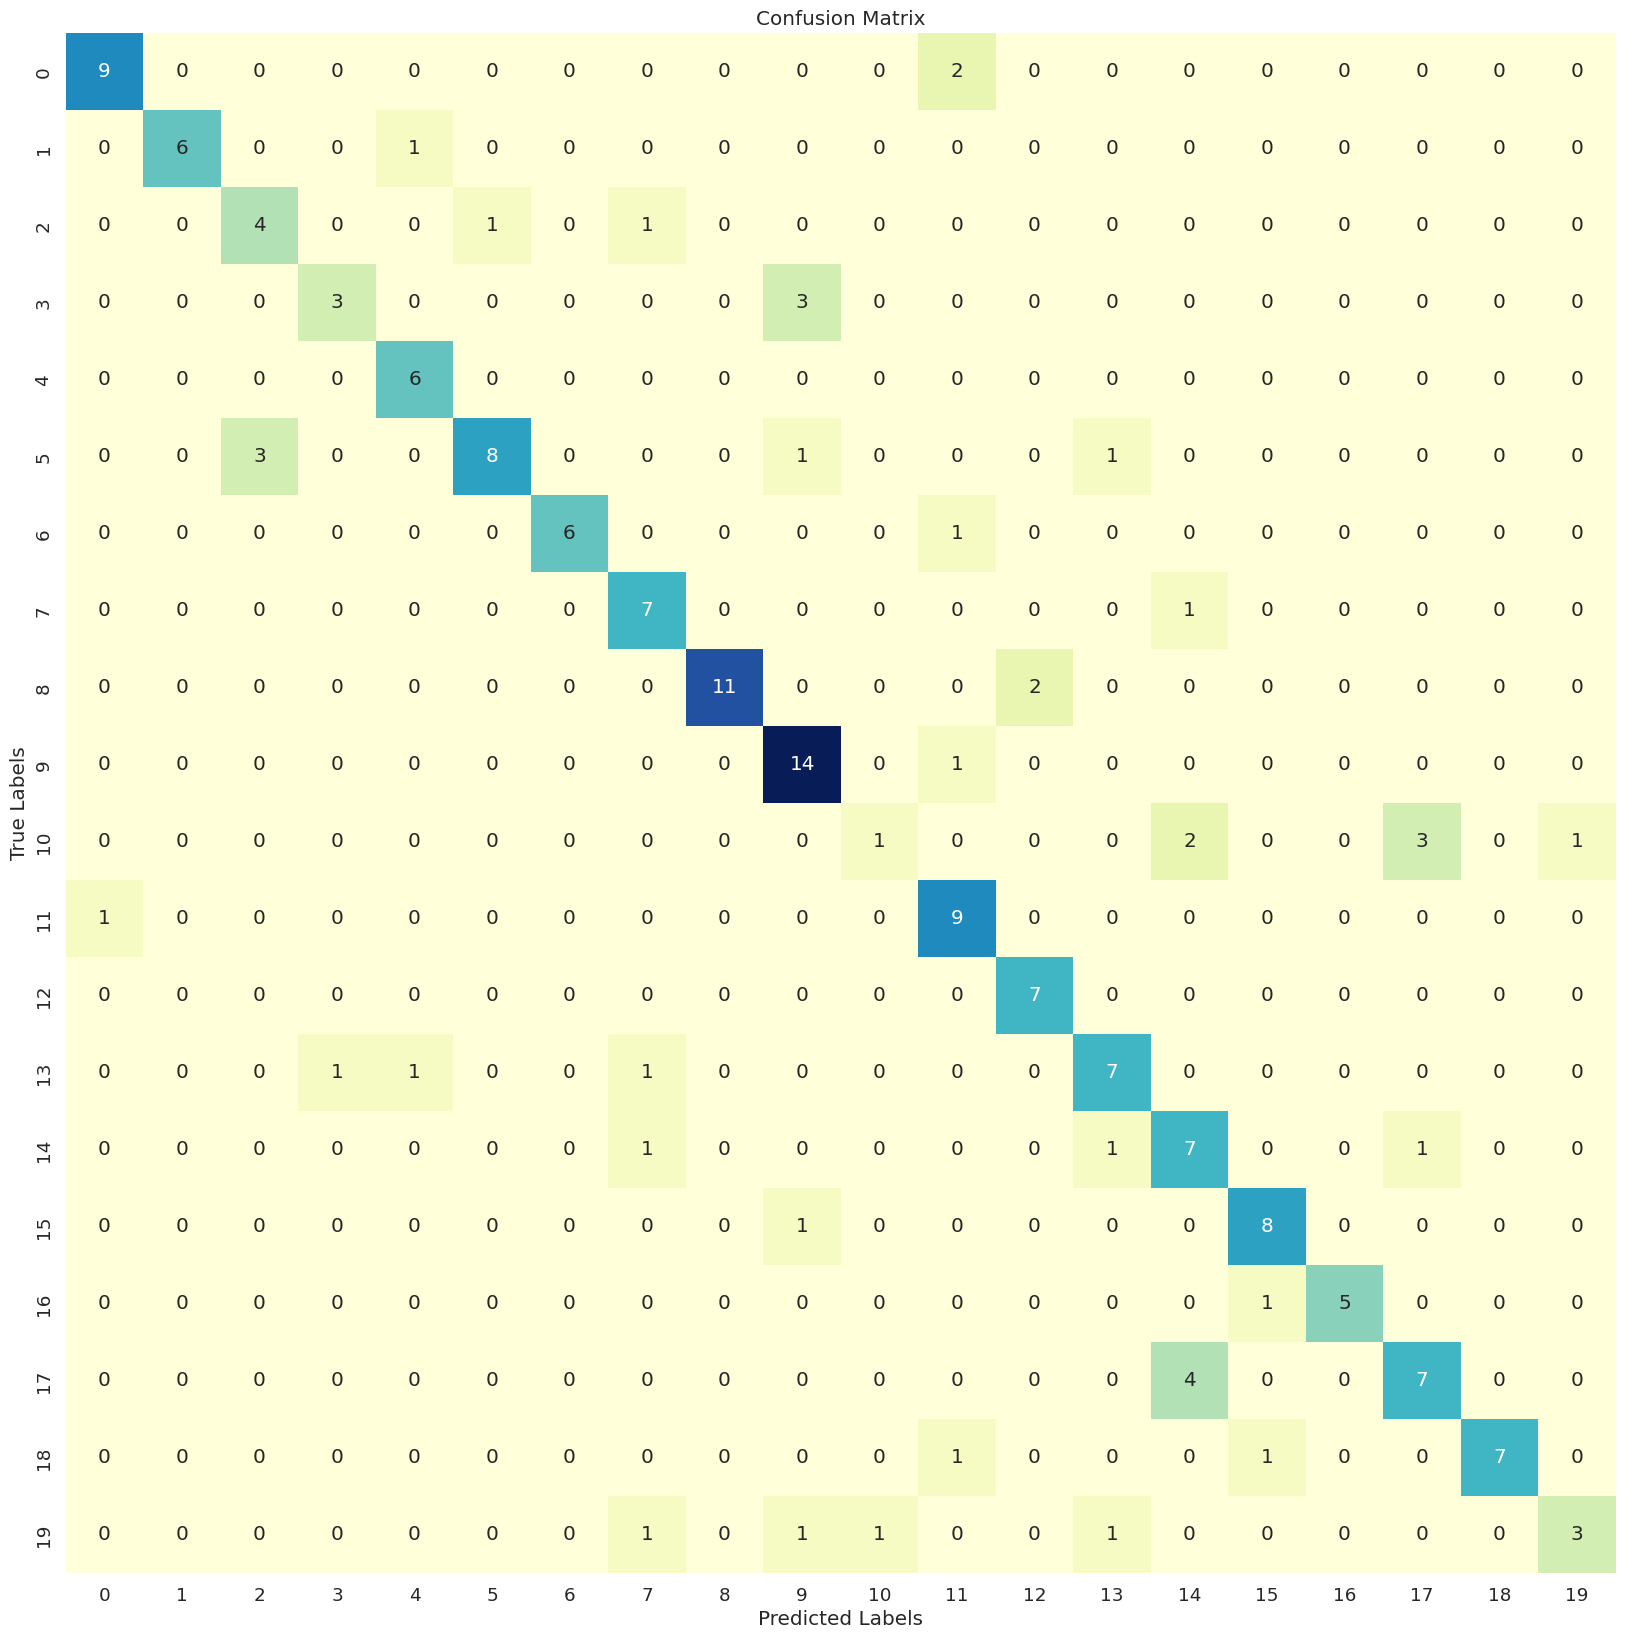

In [188]:
plt.figure(figsize=(20,20))
sns.set(font_scale=1.2)  # Adjust font size for better readability

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False,
            xticklabels=range(len(labels)), yticklabels=range(len(labels)))

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.savefig('confusion.png')

# Display the plot
plt.show()


In [189]:
torch.save(model.state_dict(),'final.pth')

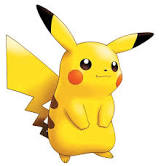

In [191]:
img = Image.open('/content/pikachu.jfif')
img

In [192]:
transformed = test_transforms(img)

In [194]:
model.eval()
with torch.inference_mode():
    output = model(transformed.unsqueeze(0).to(device))
print(output)

tensor([[-31.3398,   4.4727, -15.4555,  -5.0441,  10.2624, -16.0446, -40.5489,
           3.4371, -29.4346,  -5.6229, -13.1356, -30.1727, -26.7187,   4.6022,
          -5.0939, -27.1956, -26.6892, -15.0953, -38.1065,   4.5326]],
       device='cuda:0')


In [196]:
pred = torch.argmax(output)

In [199]:
reverse = {k:v for k,v in enumerate(labels)}
reverse

{0: 'Voltorb',
 1: 'Psyduck',
 2: 'Blastoise',
 3: 'Charizard',
 4: 'Pikachu',
 5: 'Wartortle',
 6: 'Nidoking',
 7: 'Pidgeot',
 8: 'Gengar',
 9: 'Kingler',
 10: 'Diglett',
 11: 'Electrode',
 12: 'Poliwag',
 13: 'Dragonite',
 14: 'Tauros',
 15: 'Magnemite',
 16: 'Bulbasaur',
 17: 'Golem',
 18: 'Jigglypuff',
 19: 'Abra'}

In [201]:
reverse[pred.item()]

'Pikachu'